## Find Closet Stable Pose using Brute Force Method
* This notebook provides an pipeline of how to find the closest stable pose $T_\text{part}^\text{tag}(x, y, z, \alpha, \beta, \gamma)$ to a given pose estimate $\widehat{T}_\text{part}^\text{tag}$. 
* Brute Force Method: Find the stable pose that is closest to the given estimate. The distance metric here is the **Augular Difference** between two orientation representaions.

<img src="./11_23_image_dataset/stable_pose_parametrization.jpg" width="800">

### 1 Example with make-up Estimate for Insert Mold
##### Step1: construct a list of stable poses(orientation) represented by Rotation matrices

In [266]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

In [267]:
# these two lists should be element-aligned. 
# i.e. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.array([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

def construct_R_sta_list(alphas):
    beta = 0
    # decretize gama at step of 1 degree
    gamas = np.arange(0, 360, 1)
    stable_poses_R = []
    for alpha in alphas:
        for gama in gamas:
            R = Rotation.from_euler('xyz', [alpha, beta, gama], degrees=True)
            stable_poses_R.append(R.as_matrix())
    return stable_poses_R

stable_poses_R = construct_R_sta_list(alphas_insertmold)
print("Number of stable poses to consider: ", len(stable_poses_R))

Number of stable poses to consider:  1440


##### Step2: Find the closest three stable poses by iteratively computing the angular difference

In [268]:
R_est = Rotation.from_euler('xyz', np.radians([15, 5, 145])).as_matrix()

def angular_R_diff(R1, R2):
    R_diff = R1.T @ R2
    trace = np.trace(R_diff)
    angular_distance = np.rad2deg(np.arccos((trace - 1.) / 2.))
    return angular_distance

def find_top3_stable_poses(stable_poses_R, R_est, isPrint = True):
    angular_diffs = []
    for R_sp in stable_poses_R:
        angular_diffs.append(angular_R_diff(R_sp, R_est))

    # Get indices of the top three smallest angular differences
    top3_indices = np.argsort(angular_diffs)[:3]
    # Extract the corresponding rotation matrices
    top3_stable_poses_diff = [angular_diffs[i] for i in top3_indices]
    top3_stable_poses_R = [stable_poses_R[i] for i in top3_indices]

    if(isPrint):
        # Print the top three stable poses and their angular differences
        print("Estimate's euler angles:", Rotation.from_matrix(R_est).as_euler('xyz', degrees=True))
        print()
        for i, (matrix, diff) in enumerate(zip(top3_stable_poses_R, top3_stable_poses_diff)):
            euler_angles = Rotation.from_matrix(matrix).as_euler('xyz', degrees=True)
            print(f"##### Top {i + 1} Stable Pose #####")
            # print("Rotation Matrix of stable pose {i+1}:")
            # print(matrix)
            print(f"Euler Angles of stable pose {i+1} (degrees):", euler_angles)
            print(f"Angular Difference: {diff:.2f} degrees")
            print()

    return top3_stable_poses_R

def find_closest_stable_pose(stable_poses_R, R_est):
    angular_diffs = []
    for R_sp in stable_poses_R:
        angular_diffs.append(angular_R_diff(R_sp, R_est))

    # Get indices of the top three smallest angular differences
    top_index = np.argsort(angular_diffs)[0]
    # Extract the corresponding rotation matrices
    closest_stable_poses_R = stable_poses_R[top_index]
    return closest_stable_poses_R

top3_stable_poses_R = find_top3_stable_poses(stable_poses_R, R_est)

Estimate's euler angles: [ 15.   5. 145.]

##### Top 1 Stable Pose #####
Euler Angles of stable pose 1 (degrees): [ 12.   0. 145.]
Angular Difference: 5.83 degrees

##### Top 2 Stable Pose #####
Euler Angles of stable pose 2 (degrees): [ 12.   0. 144.]
Angular Difference: 5.89 degrees

##### Top 3 Stable Pose #####
Euler Angles of stable pose 3 (degrees): [ 12.   0. 146.]
Angular Difference: 5.94 degrees



In [269]:
def construct_T(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

R_sta = find_closest_stable_pose(stable_poses_R, R_est)
R_est = R_est
t = np.array([0, 0, 0])

# Construct transformation matrices
T_sta = construct_T(R_sta, t)
T_est = construct_T(R_est, t)

print("Transformation Matrix for Estimated Pose:")
print(T_est)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta)
print("Euler angles for closest stable pose:", Rotation.from_matrix(T_sta[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Angular Difference: ", angular_R_diff(T_est[:3, :3], T_sta[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[-0.81603492 -0.57251037  0.07949139  0.        ]
 [ 0.5713938  -0.77830163  0.26029925  0.        ]
 [-0.08715574  0.25783416  0.96225019  0.        ]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [ 15.   5. 145.]

Transformation Matrix for Stable Pose:
[[-8.19152044e-01 -5.61042415e-01  1.19253247e-01  0.00000000e+00]
 [ 5.73576436e-01 -8.01251607e-01  1.70311287e-01  0.00000000e+00]
 [ 6.93889390e-18  2.07911691e-01  9.78147601e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Euler angles for closest stable pose: [ 12.   0. 145.]

Angular Difference:  5.8304620260672655 degrees


##### Step3: Create helper functions to draw results.

In [270]:
def draw_frame(ax, R, t, s=1., linewidth=1., linestyle='-'):
    t = np.reshape(t, -1)
    R = np.reshape(R, (3,3))
    o = t + R @ np.array([0., 0., 0.])
    x = t + R @ np.array([s, 0., 0.])
    y = t + R @ np.array([0., s, 0.])
    z = t + R @ np.array([0., 0., s])
    ax.plot(o[0], o[1], o[2], 'k.')
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]], 'r', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]], 'g', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]], 'b', linewidth=linewidth, linestyle=linestyle)

def draw_view(ax, elev, azim, roll, T_sta, T_est, s=1.):
    ax.set_proj_type('ortho')
    
    # Pose estimate
    draw_frame(
        ax,
        T_est[:3, :3],
        T_est[:3, 3],
        s=s,
    )
    
    # Stable pose that is closest to pose estimate
    draw_frame(
        ax,
        T_sta[:3, :3],
        T_sta[:3, 3],
        s=s,
        linewidth=3.,
        linestyle='--',
    )
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([0, 1, 2])
    
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim, roll=roll)

def draw_results(T_sta, T_est, s=1.):
    fig, (ax, ax_x, ax_y, ax_z) = plt.subplots(1, 4, figsize=(20, 60), subplot_kw={'projection': '3d'})
    draw_view(ax, 15., 30., 0., T_sta, T_est, s=s)
    draw_view(ax_x, 0., -90., 0., T_sta, T_est, s=s)
    draw_view(ax_y, 0., 0., 0., T_sta, T_est, s=s)
    draw_view(ax_z, 90., -90., 0., T_sta, T_est, s=s)
    fig.tight_layout()
    plt.show()

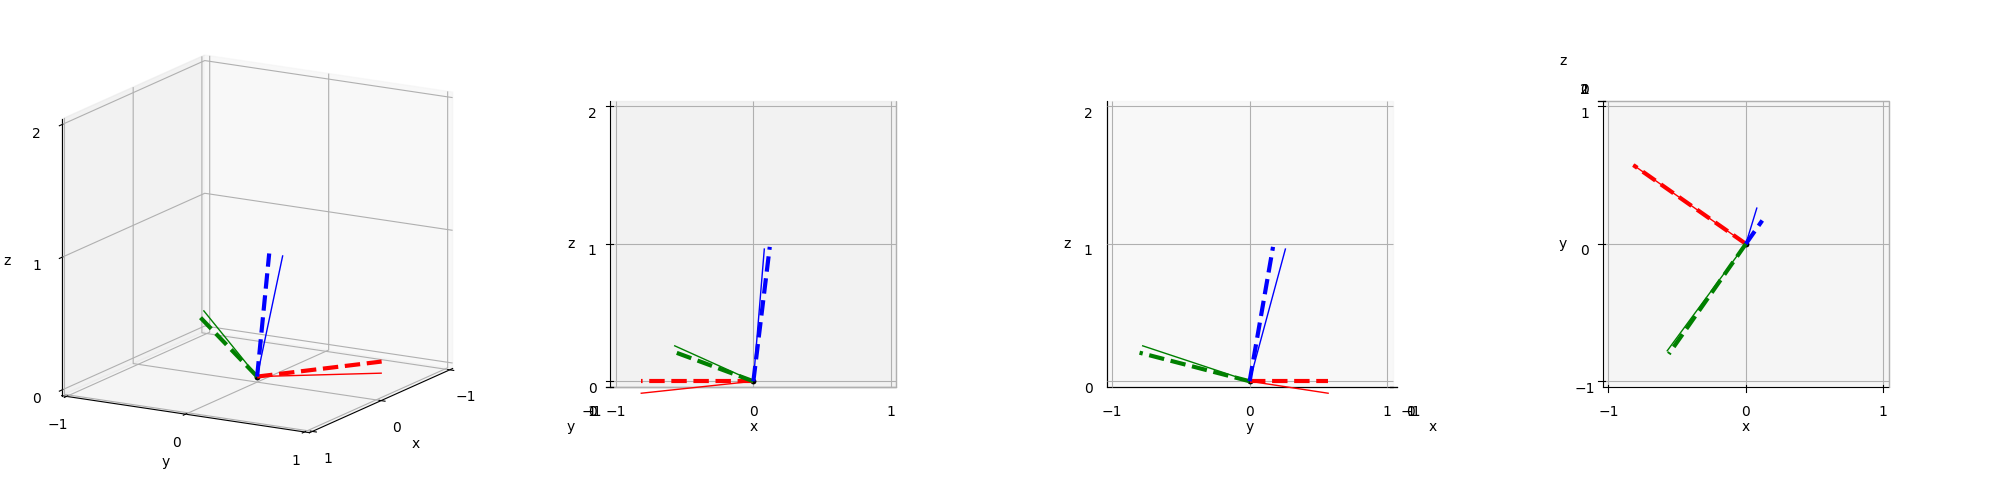

In [271]:
draw_results(T_sta, T_est)
# The solid line is for estimate
# The dashed line is for closest stable pose

### 2 Test pipeline with estimates from real experienment

#### 2.1 Insert Mold

In [272]:
data_all_instances = np.load("./11_23_image_dataset/insertmold.npz", allow_pickle=True)
print("npz file keys: ", list(data_all_instances.keys()))
print()

instance_data = data_all_instances['1'].item()
print("data keys: ", list(instance_data.keys()))
print()

T_est_in_tag = np.array(instance_data['T_part_in_tag'])
print("T_est_in_tag: \n", T_est_in_tag)
print()

R_est_in_tag = T_est_in_tag[:3, :3]
euler_angles = Rotation.from_matrix(R_est_in_tag).as_euler('xyz', degrees=True)
print("euler_angles: ", euler_angles)

npz file keys:  ['0', '1', '2', '3', '4', '5']

data keys:  ['class', 'uv', 'score', 'image_128x128', 'T_part_in_cam', 'T_part_in_tag']

T_est_in_tag: 
 [[ 0.14912385  0.97052156  0.1893409   0.081995  ]
 [-0.93966893  0.19870769 -0.27845566 -0.08568724]
 [-0.30787072 -0.13639338  0.94160101 -0.02043558]
 [ 0.          0.          0.          1.        ]]

euler_angles:  [ -8.24211695  17.93095674 -80.98245872]


In [273]:
# these two lists should be element-aligned. 
# i.e. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.array([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

stable_poses_R = construct_R_sta_list(alphas_insertmold)
print("Number of stable poses to consider: ", len(stable_poses_R))

Number of stable poses to consider:  1440


In [274]:
R_sta_in_tag = find_closest_stable_pose(stable_poses_R, T_est_in_tag[:3, :3])

def construct_T_from_R_sta_and_T_est(R_sta, T_est, alphas, z_offsets):
    alpha_sta = Rotation.from_matrix(R_sta).as_euler('xyz', degrees=True)[0]
    index = np.where(alphas == int(alpha_sta))[0]
    z_offset_sta = z_offsets[index]
    t_sta = np.array([T_est[0,3], T_est[1,3], z_offset_sta], dtype=object)
    T_sta = construct_T(R_sta, t_sta)
    return T_sta

T_sta_in_tag = construct_T_from_R_sta_and_T_est(R_sta_in_tag, T_est_in_tag, alphas_insertmold, z_offsets_insertmold)

print("Transformation Matrix for Estimated Pose:")
print(T_est_in_tag)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est_in_tag[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta_in_tag)
print("Euler angles for closest stable pose:", Rotation.from_matrix(T_sta_in_tag[:3, :3]).as_euler('xyz', degrees=True))

print()
print("Angular Difference: ", angular_R_diff(T_est_in_tag[:3, :3], T_sta_in_tag[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[ 0.14912385  0.97052156  0.1893409   0.081995  ]
 [-0.93966893  0.19870769 -0.27845566 -0.08568724]
 [-0.30787072 -0.13639338  0.94160101 -0.02043558]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [ -8.24211695  17.93095674 -80.98245872]

Transformation Matrix for Stable Pose:
[[ 0.17364818  0.98480775  0.          0.081995  ]
 [-0.98480775  0.17364818  0.         -0.08568724]
 [ 0.          0.          1.          0.0021    ]
 [ 0.          0.          0.          1.        ]]
Euler angles for closest stable pose: [  0.   0. -80.]

Angular Difference:  19.680389558343087 degrees


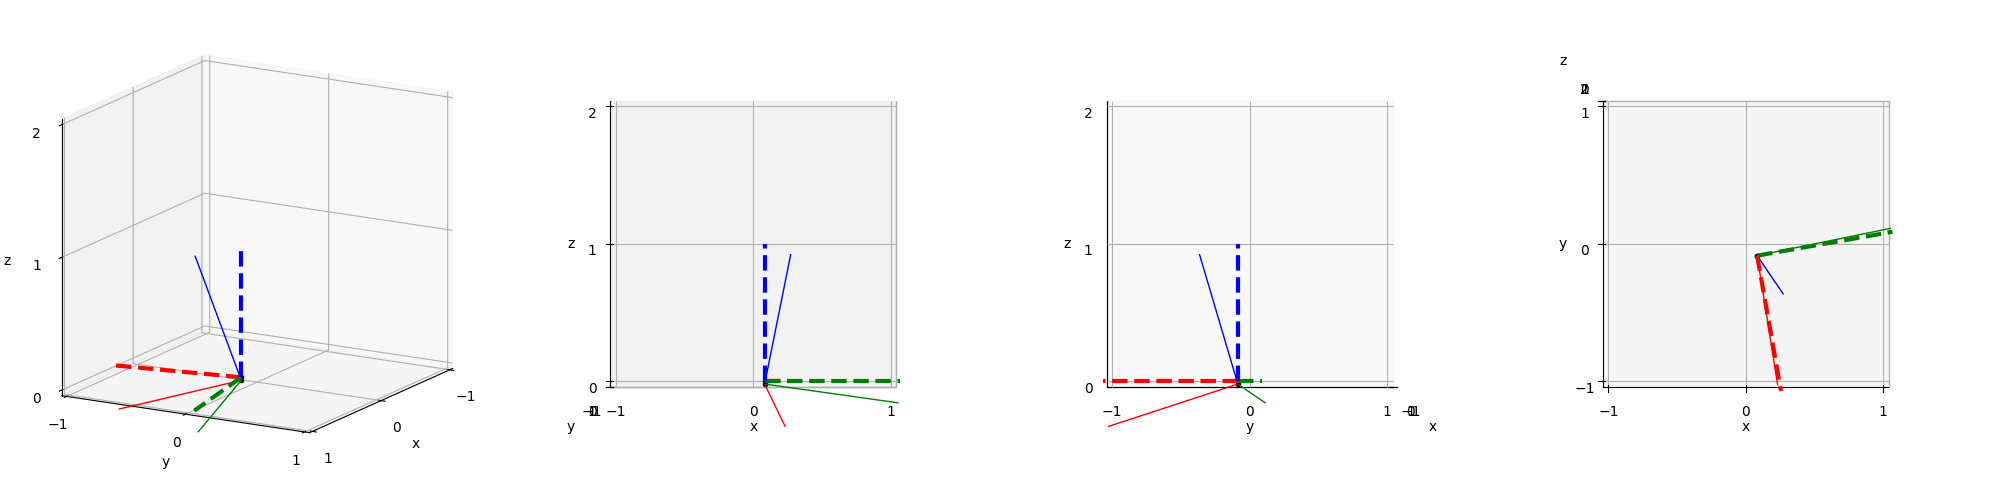

In [275]:
draw_results(T_sta_in_tag, T_est_in_tag, s=1)
# The solid line is for estimate
# The dashed line is for closest stable pose

Axes in Camera Frame (Estimated):
 [[-0.09818537 -0.96769864 -0.23220461]
 [ 0.95786848 -0.15517947  0.24167604]
 [-0.26990296 -0.19869243  0.94216437]]
Axes in Camera Frame (Stable):
 [[-0.13843128 -0.9887632  -0.05642801]
 [ 0.9896434  -0.13591952 -0.0461718 ]
 [ 0.03798331 -0.06223523  0.99733848]]
Projection (Estimated):
 [[ 67.63780244 112.70334729  61.53541294]
 [ 28.51063496  71.81003422  66.56511547]]
Projection (Stable):
 [[ 27.55470577 222.87515245  63.43421401]
 [324.54693082  85.83964193  63.53704987]]


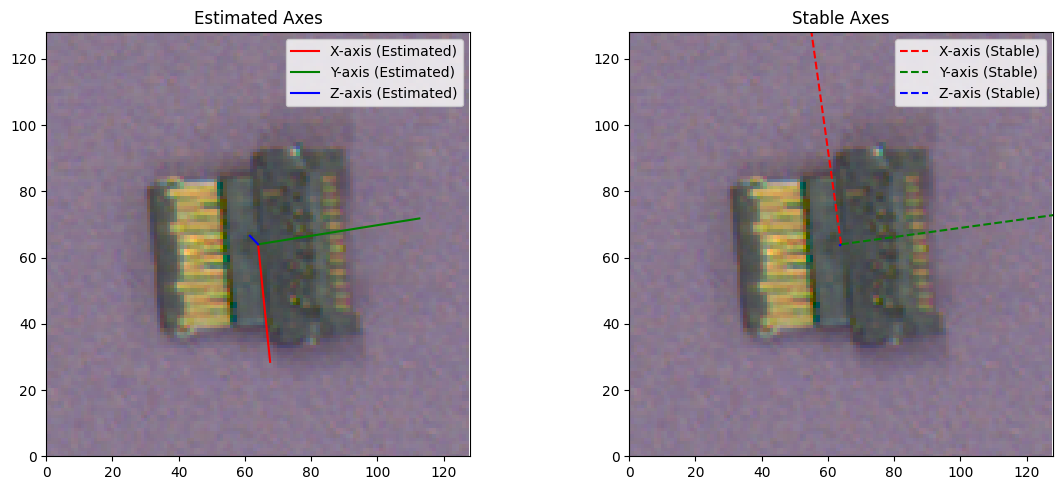

In [276]:
img = instance_data["image_128x128"]

T_tag_in_cam = np.load("./11_23_image_dataset/T_tagboard_in_cam.npy")
T_est_in_cam = T_tag_in_cam @ T_est_in_tag
T_sta_in_cam = T_tag_in_cam @ T_sta_in_tag

R_est_in_cam = T_est_in_cam[:3, :3]
R_sta_in_cam = T_sta_in_cam[:3, :3]

# Define 3D coordinates of axes in the object frame
axes_object_frame = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Transform coordinates to camera frame
axes_est_in_cam = R_est_in_cam @ axes_object_frame.T
axes_sta_in_cam = R_sta_in_cam @ axes_object_frame.T

# Print transformed axes
print("Axes in Camera Frame (Estimated):\n", axes_est_in_cam)
print("Axes in Camera Frame (Stable):\n", axes_sta_in_cam)

# Project onto 2D image plane (assuming a simple perspective projection)
focal_length = 10.0
projection_est = axes_est_in_cam[:2, :] / axes_est_in_cam[2, :] * focal_length
projection_sta = axes_sta_in_cam[:2, :] / axes_sta_in_cam[2, :] * focal_length

est_2d = projection_est + np.ones_like(projection_est) * 64
sta_2d = projection_sta + np.ones_like(projection_sta) * 64

# Print projections
print("Projection (Estimated):\n", est_2d)
print("Projection (Stable):\n", sta_2d)

# Plotting in two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot estimated axes in the first subplot
axes[0].imshow(img)  # Display the image
axes[0].plot([64, est_2d[0, 0]], [64, est_2d[1, 0]], color='red', label='X-axis (Estimated)')
axes[0].plot([64, est_2d[0, 1]], [64, est_2d[1, 1]], color='green', label='Y-axis (Estimated)')
axes[0].plot([64, est_2d[0, 2]], [64, est_2d[1, 2]], color='blue', label='Z-axis (Estimated)')
axes[0].set_xlim(0, 128)
axes[0].set_ylim(128, 0)
axes[0].invert_yaxis()
axes[0].set_title('Estimated Axes')

# Plot stable axes in the second subplot
axes[1].imshow(img)  # Display the image
axes[1].plot([64, sta_2d[0, 0]], [64, sta_2d[1, 0]], color='red', linestyle='--', label='X-axis (Stable)')
axes[1].plot([64, sta_2d[0, 1]], [64, sta_2d[1, 1]], color='green', linestyle='--', label='Y-axis (Stable)')
axes[1].plot([64, sta_2d[0, 2]], [64, sta_2d[1, 2]], color='blue', linestyle='--', label='Z-axis (Stable)')
axes[1].set_xlim(0, 128)
axes[1].set_ylim(128, 0)
axes[1].invert_yaxis()
axes[1].set_title('Stable Axes')

# Display legends
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


In [277]:
def is_rotation_matrix(R):
    # Check orthogonality
    is_orthogonal = np.allclose(np.dot(R, R.T), np.eye(3)) and np.allclose(np.dot(R.T, R), np.eye(3))

    # Check determinant
    det_R = np.linalg.det(R)
    is_valid_det = np.isclose(det_R, 1.0)

    return is_orthogonal and is_valid_det

print(is_rotation_matrix(R_est_in_cam))
print(is_rotation_matrix(R_sta_in_cam))

True
True
